In [5]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense
from sklearn.model_selection import train_test_split

df = pd.read_csv(r"C:\Users\USER\Chameleon AI-IoT\MOP-Code\artificial-intelligence\CyberSecurity\datasets\HITECH_Cleaned.csv")

# Fill missing descriptions
df['web_description'] = df['web_description'].fillna("No description provided")

# Simple text preprocessing
df['clean_text'] = df['web_description'].str.replace(r'\W', ' ', regex=True).str.lower()



In [11]:

# Tokenization and padding
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df['clean_text'])
X_seq = tokenizer.texts_to_sequences(df['clean_text'])
X_pad = pad_sequences(X_seq, maxlen=100)


In [12]:

# Encode the target labels
le = LabelEncoder()
y = le.fit_transform(df['severity_level'])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_pad, y, test_size=0.2, random_state=42)


In [18]:
from tensorflow.keras.callbacks import EarlyStopping
# Build CNN model
model = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=100),
    Conv1D(128, kernel_size=5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(32, activation='relu'),
    Dense(len(le.classes_), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Set up early stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)
# Train with early stopping
history = model.fit(
    X_train,
    y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop]
)



Epoch 1/30


C:\Users\USER\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


153/153 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.4750 - loss: 1.1868 - val_accuracy: 0.7035 - val_loss: 0.7041
Epoch 2/30
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.7327 - loss: 0.6551 - val_accuracy: 0.7569 - val_loss: 0.6061
Epoch 3/30
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.7973 - loss: 0.5090 - val_accuracy: 0.7680 - val_loss: 0.5589
Epoch 4/30
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.8397 - loss: 0.4161 - val_accuracy: 0.7459 - val_loss: 0.5927
Epoch 5/30
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.8535 - loss: 0.3655 - val_accuracy: 0.7606 - val_loss: 0.5938
Epoch 6/30
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.8513 - loss: 0.3491 - val_accuracy: 0.7551 - val_loss: 0.5896
Epoch 7/30
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.8606 - loss: 0.3265 - val_accuracy: 0.7422 - val_loss: 0.6522
Epoch 8/30
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.8540 - loss: 0.3305 - val_accuracy: 0.747

In [20]:

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)

# Display label mapping
label_mapping = pd.DataFrame({'Label': le.classes_, 'Encoded': list(range(len(le.classes_)))})
print("Label Mapping:\n", label_mapping)

# Show test results
print(f"\nTest Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7634 - loss: 0.5706
Label Mapping:
       Label  Encoded
0  Critical        0
1      High        1
2       Low        2
3  Moderate        3

Test Accuracy: 0.7671, Test Loss: 0.5926


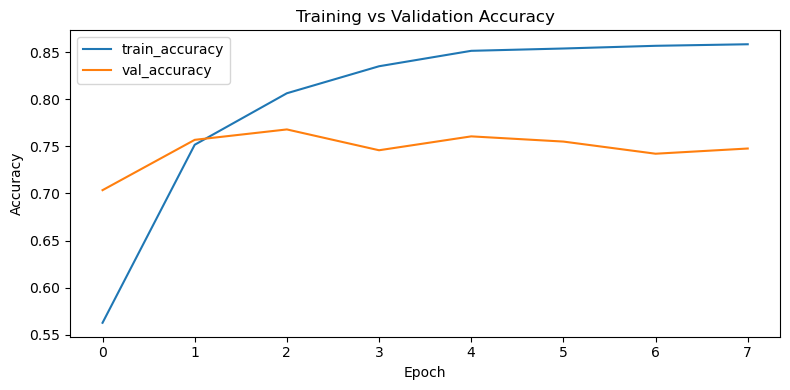

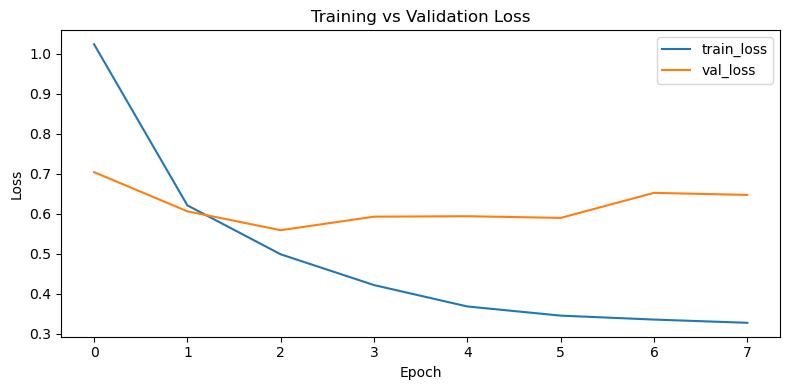

In [22]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(8,4))
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

# Plot loss
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()


In [24]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Get predicted classes on the test set
y_pred_probs = model.predict(X_test)
y_pred = y_pred_probs.argmax(axis=1)

# Print precision/recall/f1
print(classification_report(y_test, y_pred, target_names=le.classes_))


43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
              precision    recall  f1-score   support

    Critical       0.96      0.50      0.66       134
        High       0.89      0.66      0.76       304
         Low       0.86      0.59      0.70       271
    Moderate       0.70      0.94      0.80       648

    accuracy                           0.77      1357
   macro avg       0.85      0.67      0.73      1357
weighted avg       0.80      0.77      0.76      1357



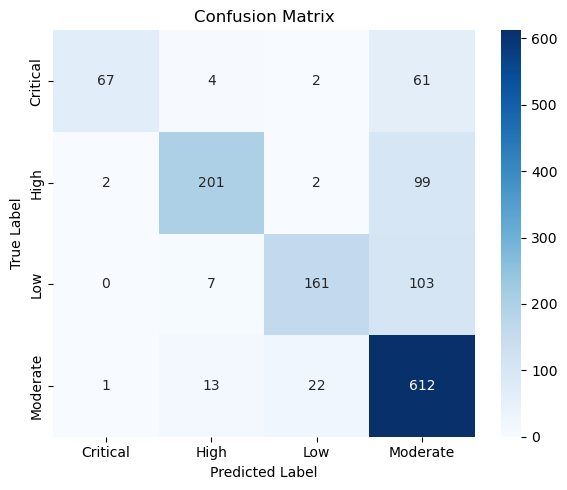

In [26]:

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=le.classes_,
            yticklabels=le.classes_,
            cmap='Blues')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()


In [41]:
# Take 5 random samples from the test set
import numpy as np

idxs = np.random.choice(len(X_test), size=5, replace=False)
for idx in idxs:
    text = df['clean_text'].iloc[X_test[idx].tolist().index(0) 
                                 if 0 in X_test[idx] else idx]
    true_label = le.inverse_transform([y_test[idx]])[0]
    pred_label = le.inverse_transform([y_pred[idx]])[0]
    print(f"True: {true_label}\tPred: {pred_label}\n  {text}\n")


True: High	Pred: High
  newton centre dental  the covered entity  ce   reported that an employee of its business associate was the subject of an email phishing scheme that compromised the protected health information  phi  of 2 547 individuals  the phi involved included names  addresses  dates of birth  drivers   license and social security numbers  diagnoses  claims and health insurance information  and other treatment information  in its mitigation efforts  the ce and ba implemented additional administrative and technical safeguards  staff were retrained on email security precautions 

True: Moderate	Pred: Moderate
  no description provided

True: Low	Pred: Low
  no description provided

True: High	Pred: Moderate
  marshall and melhorn  a business associate  ba   reported that it experienced a ransomware incident that affected the protected health information  phi  of 9 412 individuals  the phi involved included names  addresses  dates of birth  social security and drivers  license n